In [75]:
import polars as pl 
import polars_ds as pds
import polars_xdt as xdt
import polars.selectors as cs
import holidays
import os 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.category")



## Read the data 

In [76]:
data = pl.read_csv('train.csv')

Clean the column names 

In [77]:
data = (data
.select(pl.all().name.map(lambda x:x.lower()))
.select(pl.all().name.map(lambda x:x.replace("-"," ")))
.select(pl.all().name.map(lambda x:x.replace(" ","_")))
)

data.head()

row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales
i64,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,f64
1,"""CA-2017-152156""","""08/11/2017""","""11/11/2017""","""Second Class""","""CG-12520""","""Claire Gute""","""Consumer""","""United States""","""Henderson""","""Kentucky""",42420,"""South""","""FUR-BO-10001798""","""Furniture""","""Bookcases""","""Bush Somerset Collection Bookc…",261.96
2,"""CA-2017-152156""","""08/11/2017""","""11/11/2017""","""Second Class""","""CG-12520""","""Claire Gute""","""Consumer""","""United States""","""Henderson""","""Kentucky""",42420,"""South""","""FUR-CH-10000454""","""Furniture""","""Chairs""","""Hon Deluxe Fabric Upholstered …",731.94
3,"""CA-2017-138688""","""12/06/2017""","""16/06/2017""","""Second Class""","""DV-13045""","""Darrin Van Huff""","""Corporate""","""United States""","""Los Angeles""","""California""",90036,"""West""","""OFF-LA-10000240""","""Office Supplies""","""Labels""","""Self-Adhesive Address Labels f…",14.62
4,"""US-2016-108966""","""11/10/2016""","""18/10/2016""","""Standard Class""","""SO-20335""","""Sean O'Donnell""","""Consumer""","""United States""","""Fort Lauderdale""","""Florida""",33311,"""South""","""FUR-TA-10000577""","""Furniture""","""Tables""","""Bretford CR4500 Series Slim Re…",957.5775
5,"""US-2016-108966""","""11/10/2016""","""18/10/2016""","""Standard Class""","""SO-20335""","""Sean O'Donnell""","""Consumer""","""United States""","""Fort Lauderdale""","""Florida""",33311,"""South""","""OFF-ST-10000760""","""Office Supplies""","""Storage""","""Eldon Fold 'N Roll Cart System""",22.368


## Null values

Replacing empty values with null values. Only postal_code contains null values (11 nulls)

In [78]:
# It is not possible to check if numeric columns contains empty data ("" or " ")
(data
 .select(pl.all().exclude(pl.String),
         pl.when(
    (cs.string()==" ")|(cs.string()==""))
            .then(pl.lit(None))
            .otherwise(cs.string())
            .name.keep())
.null_count()
)



row_id,postal_code,sales,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,region,product_id,category,sub_category,product_name
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Preprocessing

* Changing the format on date columns. Extracting year, month and day from the function.

* Add season (Winter, spring...). This is for analyzing seasonal effects on sales

* Add holidays. Same as above.

In [79]:
# Function for changing the date format
def change_format(data,c):
 data = (data
 .with_columns(pl.col(c).str.split("/"))
 .with_columns(pl.col(c).list.get(0).cast(pl.Int64).alias(c+"_"+'day'),
              pl.col(c).list.get(1).cast(pl.Int64).alias(c+"_"'month'),
              pl.col(c).list.get(2).cast(pl.Int64).alias(c+"_"'year'))
 .with_columns(pl.concat_str([c+"_"'year',c+"_"'month',c+"_"'day'],separator="-").alias(c))
 .with_columns(pl.col(c).cast(pl.Date))
 .with_columns(pl.col(c).dt.weekday().alias(c+"_"+"weekday"),
               pl.col(c).dt.week().alias(c+"_"+"week"))
                                 )
                                 
 return data

# Add season
def season(data,c):
   data = (data
           .with_columns(season = pl.when((pl.col(c)>=3) & (pl.col(c)<=5))
                         .then(pl.lit('Spring'))
                         .when((pl.col(c)>=6) & (pl.col(c)<=8))
                         .then(pl.lit('Summer'))
                         .when((pl.col(c)>=9) & (pl.col(c)<=11))
                         .then(pl.lit('Autumn'))
                         .otherwise(pl.lit('Winter'))
           )
   )
   return data

# Add holiday 
def holiday_f(data,c):
  
 # Unique years from the data
 unique_years = data.select(c).sort(by = c).unique()[c].to_list()
 
 # Initialize lists
 h = []
 n = []
 
 # Get date and holiday name
 for date, name in holidays.US(years = unique_years).items():
     h.append(str(date))
     n.append(str(name))
 
 # Create a dataframe
 h_data = pl.DataFrame({'holiday':h,'holiday_name':n})
 h_data = h_data.with_columns(pl.col('holiday').cast(pl.Date))
 
 # Join the columns
 data = data.join(other = h_data,left_on='order_date',right_on='holiday',how='left')
 data = data.with_columns(pl.col('holiday_name').fill_null(pl.lit('Normal day')))
 return data

In [80]:
# Run functions
data = (data
.pipe(function=change_format,c = 'order_date')
.pipe(function=change_format,c = 'ship_date')
.pipe(function = season,c = 'order_date_month')
.pipe(function = holiday_f,c = 'order_date_year')
)


## Checking jumps in the data

Generate all dates between 2015 and 2018

In [81]:
from datetime import date,timedelta

# Create a polars dataframe which consists of all dates between 2015 and 2018
d = pl.DataFrame(

    pl.date_range(
    date(data.select('order_date_year').min().item(), 1, 1), 
    date(data.select('order_date_year').max().item(), 12, 31), 
    timedelta(days=1), 
    eager=True
    )
)

# Rename to date
d = d.select(pl.all().alias('date'))


# Initialize lists
h = []
n = []
   
# Get date and holiday name
for date, name in holidays.US(years = [2015,2016,2017,2018,2019]).items():
       h.append(str(date))
       n.append(str(name))
   
# Create a dataframe
h_data = pl.DataFrame({'holiday':h,'holiday_name':n})
h_data = h_data.with_columns(pl.col('holiday').cast(pl.Date))

# Join holiday to the "d"
d = d.join(other=h_data,left_on='date',right_on='holiday',how='left') 

# data.join(other=d.select('date'),left_on='order_date',right_on='date',how='full',coalesce=True)

There are 231 dates that are not present in the data. These dates could be missing. 7 of these missing dates are holidays. Hopefully, these missing dates will not have an impact on the final ML model. Some algorithms require that there are no jumps in the time series. I will impute the missing dates by when these algorithms are used.

In [82]:
# Anti join
d.join(other=data,left_on='date',right_on='order_date',how='anti')

date,holiday_name
date,str
2015-01-01,"""New Year's Day"""
2015-01-02,null
2015-01-08,null
2015-01-12,null
2015-01-17,null
…,…
2018-10-11,null
2018-10-18,null
2018-10-25,null


## Descriptive statistics

### Aggregate on year

In [83]:
agg_year = (data
.group_by(pl.col('order_date_year').cast(pl.Int64))
.agg(n_observations = pl.len(),
     n_unique_customers = pl.col('customer_id').n_unique(),
     n_unique_products = pl.col('product_id').n_unique(),
     sum_sales = pl.col('sales').sum())
.sort(by = 'order_date_year')
)

agg_year = agg_year.with_columns(pl.col('order_date_year').cast(pl.Float64))

In [84]:
agg_year.with_columns(pl.col('order_date_year').cast(pl.String))

order_date_year,n_observations,n_unique_customers,n_unique_products,sum_sales
str,u32,u32,u32,f64
"""2015.0""",1953,589,1215,479856.2081
"""2016.0""",2055,567,1226,459436.0054
"""2017.0""",2534,635,1356,600192.55
"""2018.0""",3258,690,1518,722052.0192


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='order_date_year', ylabel='sum_sales'>

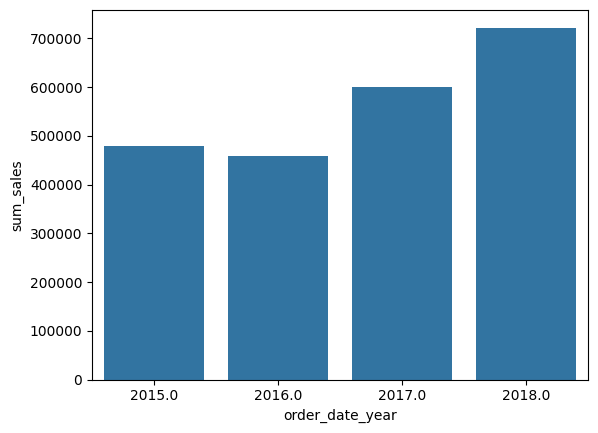

In [85]:
sns.barplot(data = agg_year.to_pandas(),x = 'order_date_year',y = 'sum_sales')

### Season

Clearly, one can see that the sales have it's peak in autumn

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='order_date_year', ylabel='sum_sales'>

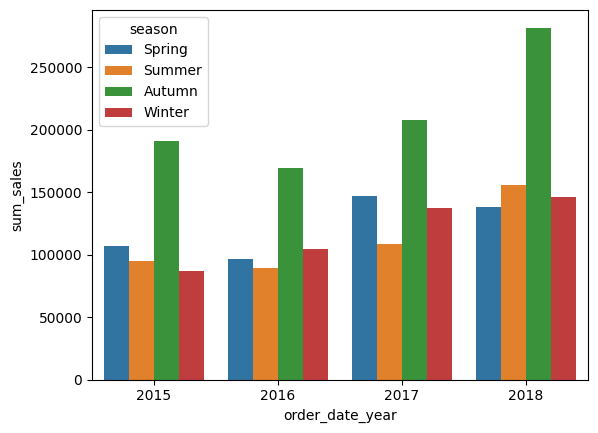

In [86]:

# Adding a "season_id" to sort the seasons in the plot.
agg_year_season = (data
.group_by(pl.col('order_date_year').cast(pl.Int64),'season')
.agg(n_observations = pl.len(),
     n_unique_customers = pl.col('customer_id').n_unique(),
     n_unique_products = pl.col('product_id').n_unique(),
     sum_sales = pl.col('sales').sum())
.with_columns(season_id = pl.when(pl.col('season')=='Spring')
              .then(pl.lit(1))
              .when(pl.col('season')=='Summer')
              .then(pl.lit(2))
              .when(pl.col('season')=='Autumn')
              .then(pl.lit(3))
              .otherwise(pl.lit(4))
)
.sort(by = ['season_id','order_date_year'],descending = [False,False])
.with_columns(pl.col('order_date_year').cast(pl.String))
)

sns.barplot(data=agg_year_season.to_pandas(),x = 'order_date_year',y = 'sum_sales',hue = 'season')

### Daily sales

There are need to dive further into the data. For instance, one can look at patterns by aggregating on week and weekday. This will be looked at in the next cells. 

Text(0.02, 0.5, 'sum_sales')

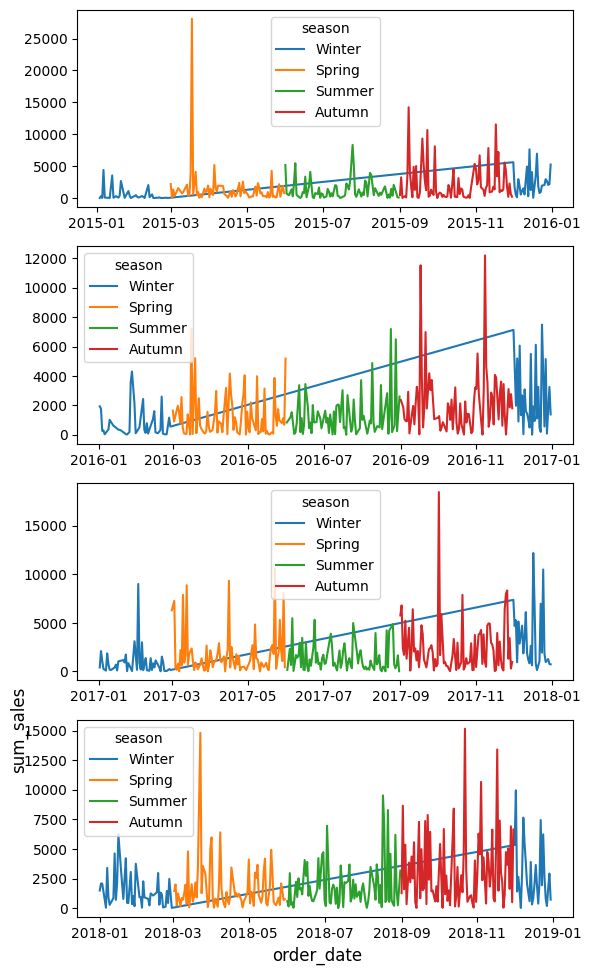

In [87]:
agg_month = (data
.group_by(pl.col('order_date'),'season')
.agg(n_observations = pl.len(),
     n_unique_customers = pl.col('customer_id').n_unique(),
     n_unique_products = pl.col('product_id').n_unique(),
     sum_sales = pl.col('sales').sum())
.with_columns(order_date_year = pl.col('order_date').dt.year().cast(pl.Int64))
.sort(by = 'order_date',descending = False)
)

# Partition by year
agg_month_partition = agg_month.partition_by(by = 'order_date_year')

# Creating subplot axes
fig, ax = plt.subplots(4,1)

for (index,year) in enumerate(agg_month_partition):
 ax[index] = sns.lineplot(data = year.to_pandas(),x = 'order_date',y = 'sum_sales',hue='season',ax = ax[index])
 ax[index].set(xlabel = "",ylabel="")

# Adjust the spacing
plt.subplots_adjust(top=2)
fig.supxlabel('order_date')
fig.supylabel('sum_sales')

In [88]:
# Aggregate on weekday
agg_weekday = (data
.group_by('order_date_weekday','order_date_year')
.agg(n_observations = pl.len(),
     n_unique_customers = pl.col('customer_id').n_unique(),
     n_unique_products = pl.col('product_id').n_unique(),
     sum_sales = pl.col('sales').sum())
.sort(by = ['order_date_weekday','order_date_year'],descending = False)
.with_columns(pl.col(['order_date_weekday','order_date_year']).cast(pl.String))
)

# Aggregate on week
agg_week = (data
.group_by('order_date_week','order_date_year','season')
.agg(n_observations = pl.len(),
     n_unique_customers = pl.col('customer_id').n_unique(),
     n_unique_products = pl.col('product_id').n_unique(),
     sum_sales = pl.col('sales').sum())
.sort(by = ['order_date_week','order_date_year'],descending = False)
.with_columns(pl.col(['order_date_week','order_date_year']).cast(pl.String))
)



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


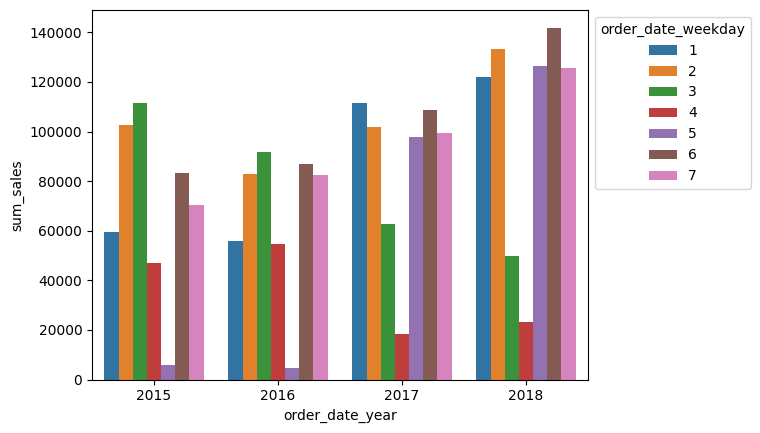

In [89]:
ax = sns.barplot(data=agg_weekday.to_pandas(),x = 'order_date_year',y = 'sum_sales',hue='order_date_weekday')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

Text(0.02, 0.5, 'sum_sales')

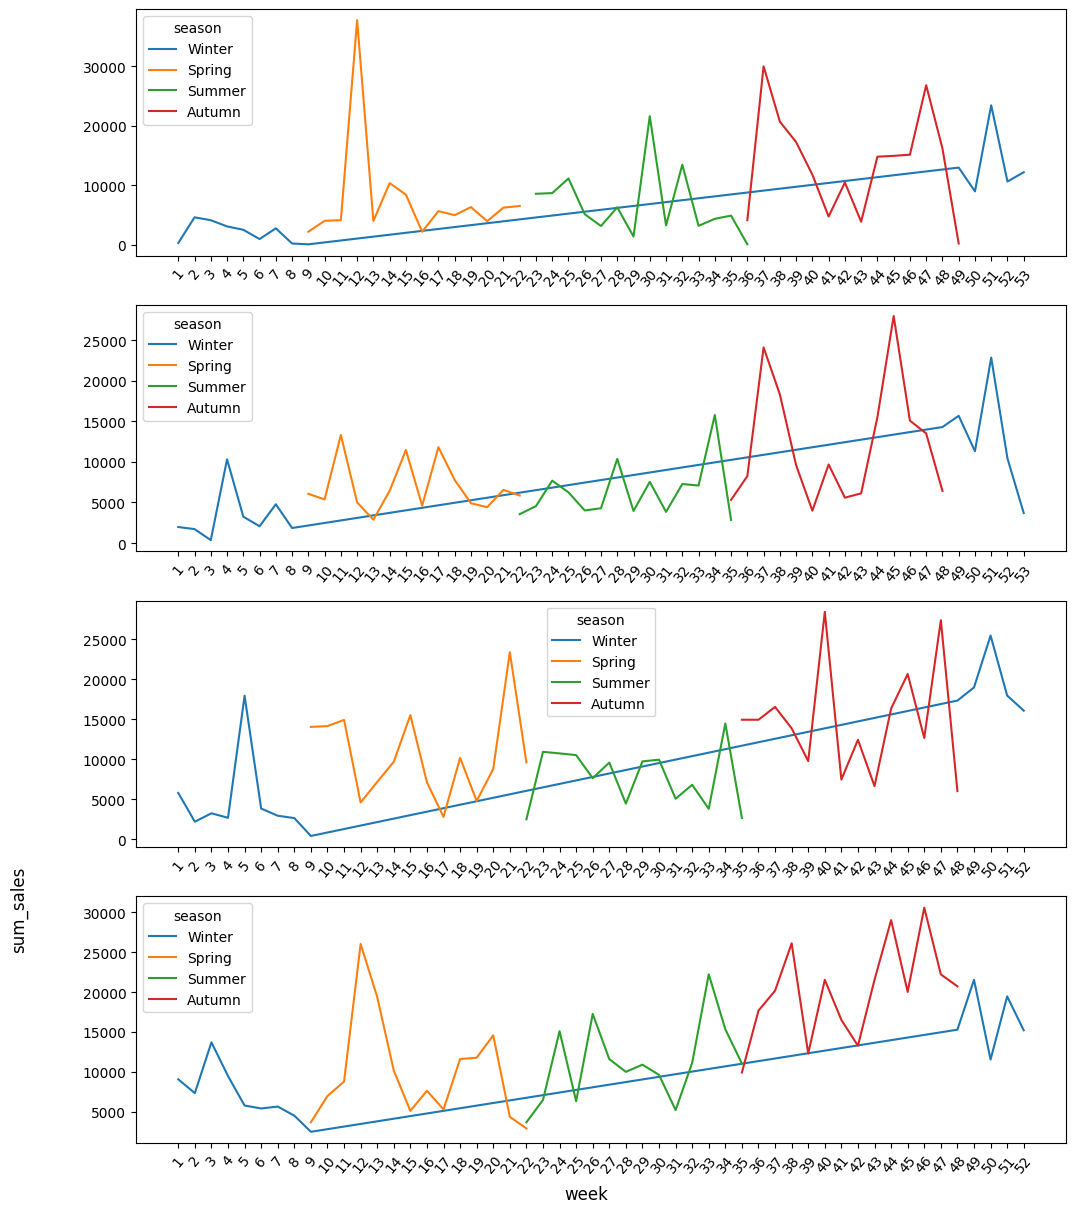

In [90]:
# Partition by year
agg_week_partition = agg_week.partition_by(by = 'order_date_year')

# Creating subplot axes
fig, ax = plt.subplots(4,1,figsize=(12,6))

for (index,year) in enumerate(agg_week_partition):
 ax[index] = sns.lineplot(data = year.to_pandas(),x = 'order_date_week',y = 'sum_sales',hue='season',ax = ax[index])
 ax[index].set(xlabel = "",ylabel="")
 ax[index].tick_params(axis='x', labelrotation=50)

# Adjust the spacing
plt.subplots_adjust(top=2)
fig.supxlabel('week')
fig.supylabel('sum_sales')

### Holiday

No clear patterns in holiday. I will still check if the final ML model gets better by including holiday as a feature.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


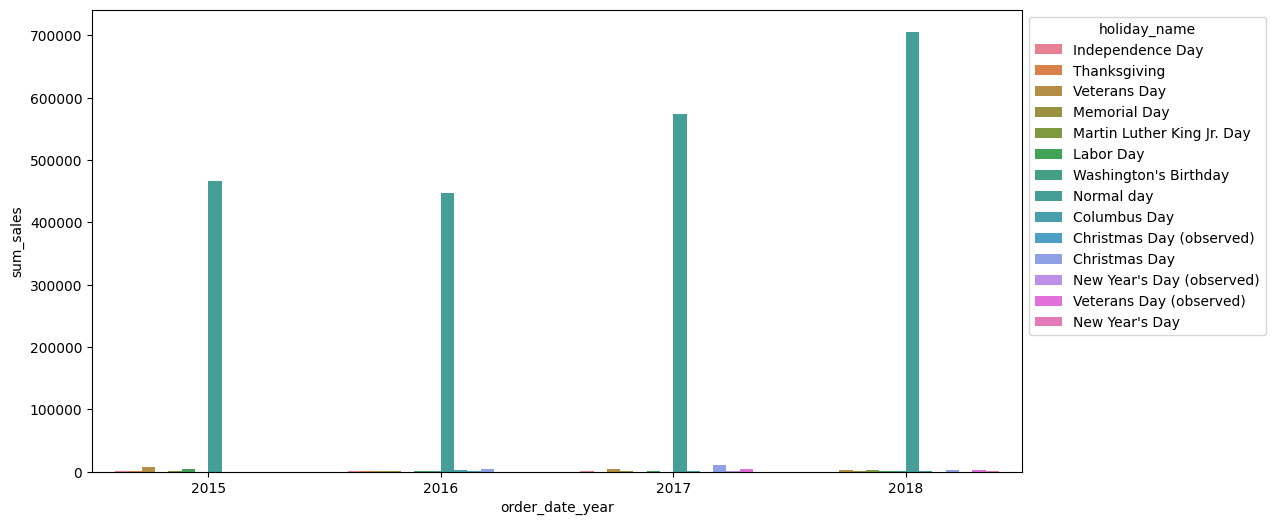

In [91]:
agg_holiday = (data
.group_by('order_date_year','holiday_name')
.agg(n_observations = pl.len(),
     n_unique_customers = pl.col('customer_id').n_unique(),
     n_unique_products = pl.col('product_id').n_unique(),
     sum_sales = pl.col('sales').sum())
.sort(by = ['order_date_year'],descending = False)
.with_columns(pl.col(['holiday_name','order_date_year']).cast(pl.String))
)


# Creating subplot axes
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax = sns.barplot(data = agg_holiday.filter(pl.col('holiday_name').is_not_null()).to_pandas(),
                 x = 'order_date_year',
                 y = 'sum_sales',
                 hue = 'holiday_name')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### Category and subcategory

#### Category

The difference betweem category sales are small.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='order_date_year', ylabel='sales'>

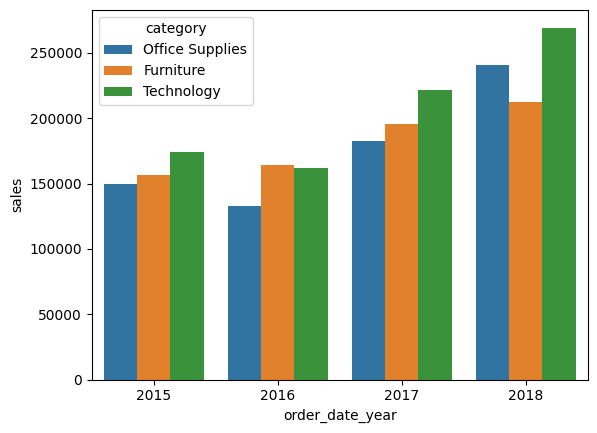

In [92]:
category = (data
.group_by('order_date_year','category')
.agg(pl.col('sales').sum())
.with_columns(pl.col('sales').sum().over('order_date_year').alias('total_category_sum'))
.sort(by = ['order_date_year','sales'])
)

sns.barplot(data = category.to_pandas(),x = 'order_date_year',y = 'sales',hue='category')



#### Subcategory

Same pattern here. By comparing total sales within category one sees small differences.

In [93]:
category_and_sub = (data
.group_by('order_date_year','category','sub_category')
.agg(pl.col('sales').sum())
.with_columns(pl.col('sales').sum().over('category','order_date_year').alias('total_category_sum'),
              pl.col('sub_category').n_unique().over('category','order_date_year').alias('n_unique_products'))
.sort(by = ['category','order_date_year','sales'])
)

# Partition the data, such that it can be looped over when creating figs.
category_and_sub_part = category_and_sub.partition_by(by=['category'])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

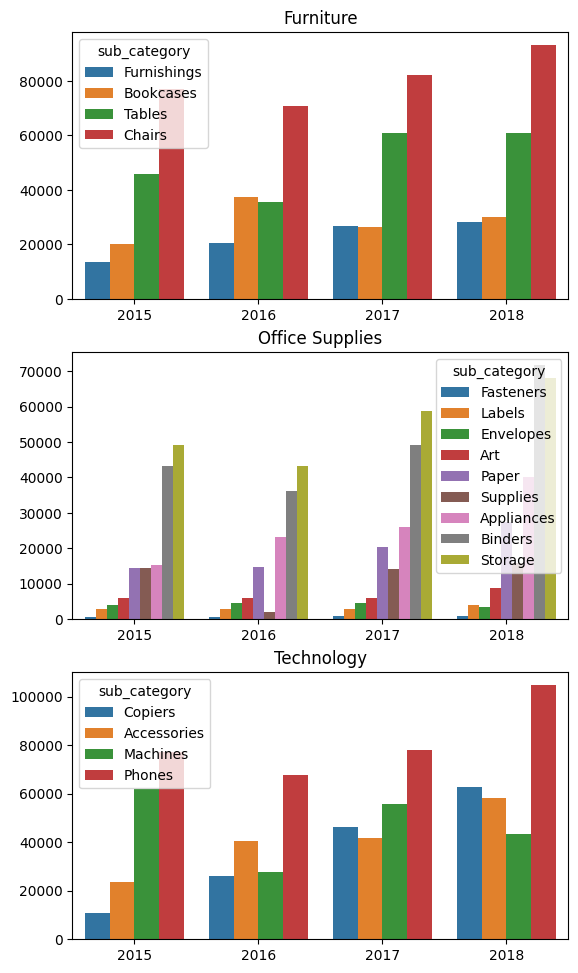

In [94]:
# Creating subplot axes
fig, ax = plt.subplots(3,1)

for (index,category) in enumerate(category_and_sub_part):
  ax[index] = sns.barplot(data = category.to_pandas(),x = 'order_date_year',y = 'sales',hue = 'sub_category',ax = ax[index])
  
  category_title = category.select('category').unique().item()
  ax[index].set(title = category_title,xlabel="",ylabel="")
   

# Adjust the spacing
plt.subplots_adjust(top=2)


## ML

Create a machine learning model that can predict the total sales the next days


In [95]:
# Sort the data
data = data.sort(by = 'order_date')

In [96]:
# Aggregate sales per day. Include day, month, year, weekday and week as features.
ml_data = (data
.group_by([c for c in data.columns if 'order_date' in c])
.agg(pl.col('sales').sum().alias('total_sales'))
.sort(by =['order_date'],descending = False)
)

# Cast the date columns as pl.Int64
ml_data = ml_data.with_columns(pl.all().exclude('total_sales','order_date').cast(pl.Int64).keep_name())
ml_data = ml_data.with_columns(pl.col('total_sales').shift(n = 1).alias('total_sales_lag_1'))

ml_data = ml_data.drop('order_date')
ml_data.head()

order_date_day,order_date_month,order_date_year,order_date_weekday,order_date_week,total_sales,total_sales_lag_1
i64,i64,i64,i64,i64,f64,f64
3,1,2015,6,1,16.448,null
4,1,2015,7,1,288.06,16.448
5,1,2015,1,2,19.536,288.06
6,1,2015,2,2,4407.1,19.536
7,1,2015,3,2,87.158,4407.1


Training and test set

In [97]:
training_n = int(ml_data.shape[0]*0.7)

X_train = ml_data.select(pl.exclude('total_sales')).head(training_n)
X_test  = ml_data.select(pl.exclude('total_sales')).tail(ml_data.shape[0] - (training_n+1))

y_train = ml_data.select(pl.col('total_sales')).head(training_n)
y_test  = ml_data.select(pl.col('total_sales')).tail(ml_data.shape[0] - (training_n+1))


In [98]:
X_train, X_test, y_train, y_test = train_test_split(ml_data.select(pl.all().exclude('total_sales')), ml_data.select('total_sales'), train_size=0.3, random_state=42)

Defining preprocessor classes

* One hot encoding based on polars 
* Lag calculations

In [99]:
# Custom transformer for sklearn pipeline
class polars_onehot_encoding(BaseEstimator, TransformerMixin):
    
    def __init__(self, column):
        self.column = column
        self.categories_ = {}

    def fit(self, X, y=None):
        # Find all unique values for each column and store them
        for col in self.column:
            self.categories_[col] = X[col].unique().to_list()
        return self

    def transform(self, X):
        # Ensure all categories are present in the dataframe
        for col, categories in self.categories_.items():
            for category in categories:
                X = X.with_columns(
                    (pl.col(col) == category).cast(pl.Int64).alias(f"{col}_{category}")
                )
        
        # Drop original columns
        X = X.drop(self.column)
        return X

# Creating lag variables
class polars_lag_variables(BaseEstimator, TransformerMixin):
    def __init__(self,column,lag_periods):
        self.column = column
        self.lag_periods = lag_periods
    
    def fit(self,X,y = None):
        return(self)
    
    def transform(self, X):
     expr_lags = []
     for n in range(1, self.lag_periods + 1):
         expr_lags.append(pl.col(self.column).shift(n=int(n)).alias(self.column + "_lag_" + str(n)))

     X = X.with_columns(*expr_lags)
     X = X.drop(self.column)
     return X


Define pipeline

In [100]:

# Definer preprosessor
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoding_pl', polars_onehot_encoding(column=['category', 'sub_category']), ['category', 'sub_category']),
        ('lag_variables', polars_lag_variables(column='mean_across_states', lag_periods=1), ['mean_across_states'])
    ],
    remainder='passthrough'
)

# Into pipeline
pipeline = Pipeline([#('preprocessor',preprocessor),
                     ('xgb_regressor',XGBRegressor())
                      ])



In [101]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('xgb_regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

I get a terrible model. Tried do dig into the data to look for reasons why the model is so bad, but could not find any clear reasons. A possible solution is to  remove outliers. I added lagged variables but this did not contribute to a better model.

In [102]:
f'training R2 :  {r2_score(y_train, pipeline.predict(X_train))}, test R2 :{r2_score(y_test, pipeline.predict(X_test))}'

'training R2 :  0.9998234026855539, test R2 :-0.7682134111348142'

## Lets try prophet

In [103]:
from prophet import Prophet

# Create a forecast window
forecast_window = int(ml_data.shape[0]*0.9)

# Aggregate sales per day. Include day, month, year, weekday and week as features.
ml_data = (data
.group_by(pl.col('order_date').alias('ds'))
.agg(pl.col('sales').sum().alias('y'))
.sort(by =['ds'],descending = False)
)


# The training data
ml_data_train     = ml_data.filter(pl.col('ds').dt.year()<=2017)

# Forecast data
ml_data_forecast  = ml_data.filter(pl.col('ds').dt.year()>2017)


# Initialize model
model = Prophet()



DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path


Train the model

In [104]:
model.fit(ml_data_train.to_pandas())

DEBUG:cmdstanpy:input tempfile: C:\Users\YAFEEI~1\AppData\Local\Temp\tmpcc96md3v\87whv5o3.json
DEBUG:cmdstanpy:input tempfile: C:\Users\YAFEEI~1\AppData\Local\Temp\tmpcc96md3v\pzac3dmp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Yafee Ishraq\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=56956', 'data', 'file=C:\\Users\\YAFEEI~1\\AppData\\Local\\Temp\\tmpcc96md3v\\87whv5o3.json', 'init=C:\\Users\\YAFEEI~1\\AppData\\Local\\Temp\\tmpcc96md3v\\pzac3dmp.json', 'output', 'file=C:\\Users\\YAFEEI~1\\AppData\\Local\\Temp\\tmpcc96md3v\\prophet_model70mt66ei\\prophet_model-20240717230309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:03:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:03:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Create a forecast

In [105]:
# Create forecast
future   = model.make_future_dataframe(periods=ml_data_forecast.shape[0]+1)
forecast = model.predict(future)

# Transform to polars
forecast = pl.from_pandas(forecast)
forecast = forecast.with_columns(pl.col('ds').cast(pl.Date))

# Remove null values from the data by inner join
forecast = forecast.join(other = ml_data,on = 'ds',how = 'inner').select('ds','y','yhat')

<Axes: xlabel='ds', ylabel='value'>

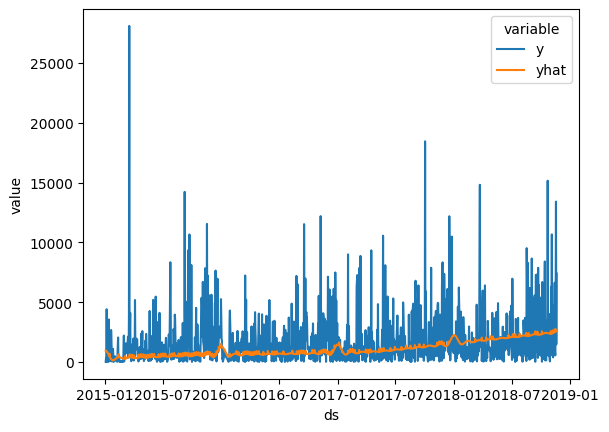

In [106]:
forecast = forecast.melt(id_vars='ds').sort(by = ['ds','variable'])
sns.lineplot(data=forecast.to_pandas(),x = 'ds',y = 'value',hue='variable')